<a href="https://colab.research.google.com/github/yeseulha/TensorFlow/blob/master/Confusion_Matrix%EA%B9%8C%EC%A7%80_%EB%A7%88%EC%A7%80%EB%A7%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# 런타임 -> 런타임 유형변경 -> 하드웨어 가속도 TPU변경
%tensorflow_version 2.x
#런타임 -> 런타임 다시시작

In [0]:
from google.colab import files 

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn]))) 

Saving data3.zip to data3.zip
Saving test.zip to test.zip
User uploaded file "data3.zip" with length 5239219 bytes
User uploaded file "test.zip" with length 97894 bytes


In [0]:
! mkdir data3                       # 마운트에 폴더 생성
! unzip data3.zip -d ./data3    # unzip 
! mkdir test                       # 마운트에 폴더 생성
! unzip test.zip -d ./test   # unzip 

Archive:  data3.zip
   creating: ./data3/data3/cardboard/
  inflating: ./data3/data3/cardboard/cardboard1.jpg  
  inflating: ./data3/data3/cardboard/cardboard10.jpg  
  inflating: ./data3/data3/cardboard/cardboard100.jpg  
  inflating: ./data3/data3/cardboard/cardboard101.jpg  
  inflating: ./data3/data3/cardboard/cardboard102.jpg  
  inflating: ./data3/data3/cardboard/cardboard103.jpg  
  inflating: ./data3/data3/cardboard/cardboard104.jpg  
  inflating: ./data3/data3/cardboard/cardboard105.jpg  
  inflating: ./data3/data3/cardboard/cardboard106.jpg  
  inflating: ./data3/data3/cardboard/cardboard107.jpg  
  inflating: ./data3/data3/cardboard/cardboard108.jpg  
  inflating: ./data3/data3/cardboard/cardboard109.jpg  
  inflating: ./data3/data3/cardboard/cardboard11.jpg  
  inflating: ./data3/data3/cardboard/cardboard110.jpg  
  inflating: ./data3/data3/cardboard/cardboard111.jpg  
  inflating: ./data3/data3/cardboard/cardboard112.jpg  
  inflating: ./data3/data3/cardboard/cardboard113.

In [0]:
import os
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import tensorflow as tf
from tensorflow import keras 
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from keras import backend as K
from tensorflow.keras.optimizers import Adam

from PIL import Image

from sklearn.metrics import confusion_matrix
from sklearn import preprocessing


In [0]:
train_dir = 'data3/data3/'
label_nums = os.listdir('data3/data3')
label_nums

['metal', 'paper', 'glass', 'trash', 'plastic', 'cardboard']

In [0]:
lbl_n = label_nums[0]
'data3/data3/' + lbl_n

nums_dataset = []

for lbl_n in label_nums:
    data_per_class = os.listdir('data3/data3/' + lbl_n)
    nums_dataset.append(len(data_per_class))

nums_dataset 

[410, 584, 501, 137, 482, 403]

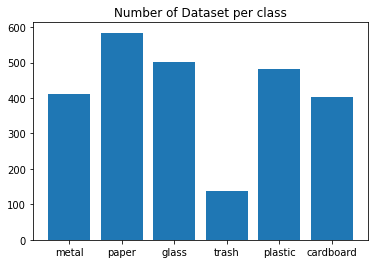

In [0]:
plt.bar(label_nums, nums_dataset)
plt.title('Number of Dataset per class')
plt.show()

# Hyperparameter Tunning

In [0]:
num_epochs = 400
batch_size = 32

learning_rate = 0.001

input_shape = (96, 128, 3)

# Image Augumentation

In [0]:
train_datagen =  ImageDataGenerator(
    rescale=1./255.,
    rotation_range = 20,
    width_shift_range=0.4,
    height_shift_range = 0.3,
     shear_range=0.3,
    zoom_range = 0.2,
    horizontal_flip=True,
    vertical_flip = True,
    validation_split = 0.2
)

test_datagen = ImageDataGenerator(
    rescale=1./255.
   )

In [0]:
test_batch_size = 250

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],  
    batch_size = batch_size,
    shuffle=True,
    class_mode='categorical'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size = test_batch_size,
    class_mode='categorical',
    subset='validation'
)




Found 2517 images belonging to 6 classes.
Found 501 images belonging to 6 classes.


# Bulid Model

In [0]:
# Functional 모델 층 구성하기
def create_model():
    inputs = keras.Input(input_shape)
    conv1 = keras.layers.Conv2D(filters=32, kernel_size=[3, 3], padding='SAME', activation=tf.nn.relu)(inputs)
    pool1 = keras.layers.MaxPool2D(padding='SAME')(conv1)
    conv2 = keras.layers.Conv2D(filters=64, kernel_size=[3, 3], padding='SAME', activation=tf.nn.relu)(pool1)
    pool2 = keras.layers.MaxPool2D(padding='SAME')(conv2)
    conv3 = keras.layers.Conv2D(filters=128, kernel_size=[3, 3], padding='SAME', activation=tf.nn.relu)(pool2)
    pool3 = keras.layers.MaxPool2D(padding='SAME')(conv3)
    pool3_flat = keras.layers.Flatten()(pool3)
    dense4 = keras.layers.Dense(units=256, activation=tf.nn.relu)(pool3_flat)
    drop4 = keras.layers.Dropout(rate=0.4)(dense4)
    logits = keras.layers.Dense(units=6, activation=tf.nn.softmax)(drop4)
    return keras.Model(inputs=inputs, outputs=logits)

In [0]:
model = create_model() # 모델 함수를 model로 변경
model.summary() # 모델에 대한 요약 출력해줌

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 96, 128, 3)]      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 96, 128, 32)       896       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 48, 64, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 48, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 24, 32, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 24, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 12, 16, 128)       0   

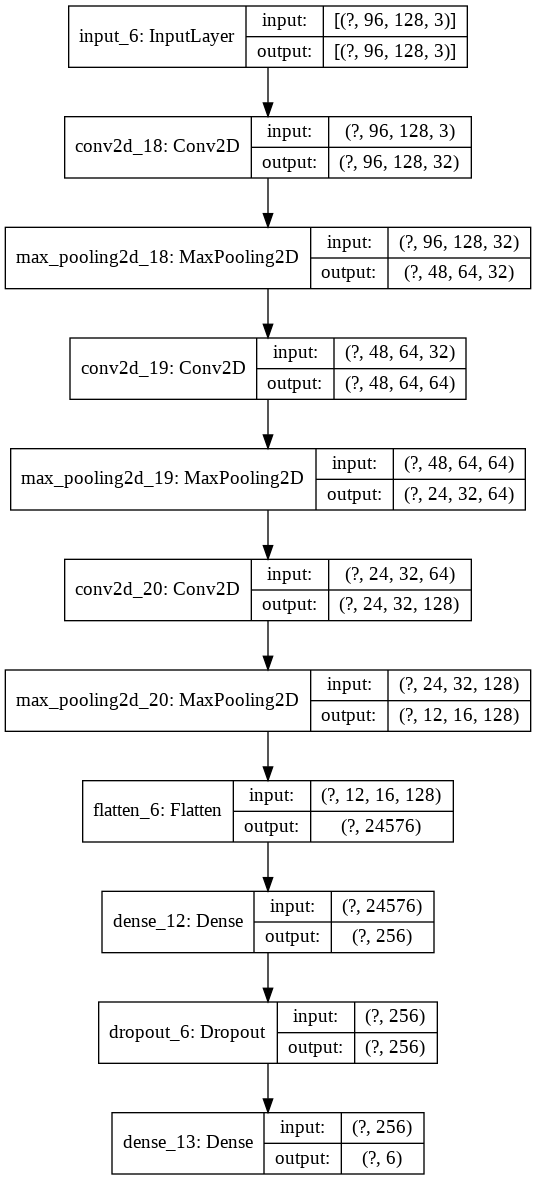

In [0]:
# 위에서 정한 모델을 그림으로(plot) 보여줌
keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True) 

In [0]:
from keras import optimizers

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate),
              metrics=['accuracy'])

###### EarlyStopping을 사용해 val_acc의 개선이 30에포크가 지나도 없다면 학습을 조기종료 시키겠습니다.

In [0]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = [EarlyStopping(monitor = 'val_accuracy', patience = 30)]

# Training

In [0]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator), 
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=early_stop, 
    verbose =1)

Epoch 1/400
79/79 [==============================] - 10s 127ms/step - loss: 0.9688 - accuracy: 0.6389 - val_loss: 1.0257 - val_accuracy: 0.5848
Epoch 2/400
79/79 [==============================] - 10s 129ms/step - loss: 0.9553 - accuracy: 0.6377 - val_loss: 1.0143 - val_accuracy: 0.5908
Epoch 3/400
79/79 [==============================] - 10s 128ms/step - loss: 0.9833 - accuracy: 0.6242 - val_loss: 1.0007 - val_accuracy: 0.5429
Epoch 4/400
79/79 [==============================] - 10s 127ms/step - loss: 0.9089 - accuracy: 0.6488 - val_loss: 0.9550 - val_accuracy: 0.6327
Epoch 5/400
79/79 [==============================] - 10s 129ms/step - loss: 0.9461 - accuracy: 0.6579 - val_loss: 1.0464 - val_accuracy: 0.6208
Epoch 6/400
79/79 [==============================] - 10s 129ms/step - loss: 0.9339 - accuracy: 0.6615 - val_loss: 1.0226 - val_accuracy: 0.5988
Epoch 7/400
79/79 [==============================] - 10s 128ms/step - loss: 0.9055 - accuracy: 0.6675 - val_loss: 0.9568 - val_accuracy:

# 학습 모델 저장하기

In [0]:
model.save('cnn_garbage_model.h5') # 모델 아키텍처와 모델 가중치 저장

In [0]:
from tensorflow.keras.models import load_model
model = load_model('cnn_garbage_model.h5')

In [0]:
model.evaluate_generator(validation_generator)

[0.28086134791374207, 0.8982036113739014]

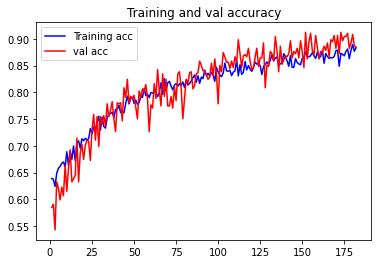

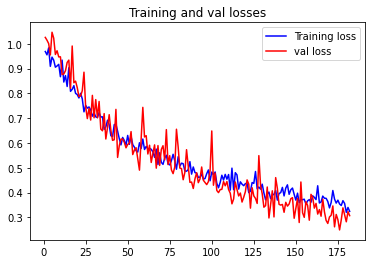

In [0]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(acc)+1)
plt.title('Training and val accuracy')
plt.plot(epochs,acc,'blue',label='Training acc')
plt.plot(epochs,val_acc,'red',label='val acc')
plt.legend()

plt.figure()
plt.title('Training and val losses')
plt.plot(epochs,loss,'blue',label='Training loss')
plt.plot(epochs,val_loss,'red',label='val loss')
plt.legend()
plt.show()

# Confusion_matrix 계산하기 - 테스트 데이터셋 사용 

In [0]:
temp_val_gen=train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=200,
    class_mode='categorical',
    seed=1,
    subset='validation'
)    

Found 501 images belonging to 6 classes.


In [0]:
x_val,y_true=next(temp_val_gen)

In [0]:
y_pred=model.predict(x_val)

In [0]:
y_pred.shape

(200, 6)

In [0]:
# predictions = [i.argmax() for i in y_pred]
# y_true = [i.argmax() for i in test_labels]
# predictions
y_pred=np.argmax(y_pred,axis=1)
y_true=np.argmax(y_true,axis=1)

In [0]:
def plot_confusion_matrix(cm, target_names,title='Confusion matrix',cmap=None,normalize=False):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float32') / cm.sum(axis=1)
        cm = np.round(cm,2)
        

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel("Predicted label\naccuracy={:0.4f}\n misclass={:0.4f}".format(accuracy, misclass))
    plt.show()

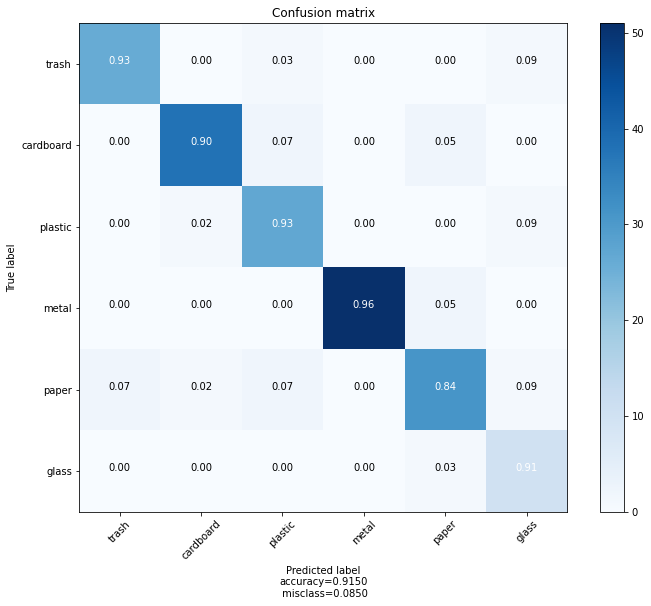

In [0]:
lbls = ['trash', 'cardboard', 'plastic', 'metal', 'paper', 'glass']
cm = confusion_matrix(y_pred, y_true)
plot_confusion_matrix(cm, normalize=True, target_names=lbls)

In [0]:
#test_generator=test_datagen.flow_from_directory(
#    test_dir,
#    target_size=input_shape[:2],
#    batch_size=18,
#    class_mode='categorical',
#   seed=1
#)    

#model.evaluate_generator(test_generator)